In [1]:
import os, os.path
import glob
import pickle
import numpy as np
from numpy.polynomial import Polynomial
from scipy import ndimage, signal, interpolate
#import matplotlib
#matplotlib.use('PDF')
from galpy.orbit import Orbit
from galpy.potential import MWPotential2014
from galpy.util import bovy_conversion, save_pickles, bovy_coords, bovy_plot
import pal5_util
from gd1_util import R0, V0
import custom_stripping_df
import seaborn as sns
import astropy.units as u
from galpy import potential
%pylab inline
from matplotlib import cm, pyplot
#from matplotlib.ticker import FuncFormatter, NullFormatter

def galcencyl_to_lbd(R,phi,Z,degree=True):
    xyz=bovy_coords.galcencyl_to_XYZ(R,phi,Z)
    lbd=bovy_coords.XYZ_to_lbd(xyz[0],xyz[1],xyz[2],degree=degree)
    return lbd[0], lbd[1], lbd[2]

Populating the interactive namespace from numpy and matplotlib


In [2]:
from scipy import integrate
import numpy as np

#constants
x0=1.49 # kpc
y0=0.58
z0=0.4
q= 0.6
r0=np.sqrt(x0**2 + y0**2 + z0**2)

Mbar=10**10 #Msun

def r1(z,y,x):
    return (((x/x0)**2. + (y/y0)**2.)**2. + (z/z0)**4)**(0.25)

def r2(z,y,x):
    return (1/z0)*(q*(x**2 + y**2) + z**2)**(0.5)

def rho_bar(z,y,x):
    return np.exp(-0.5*r1(z,y,x)**2.) + (r2(z,y,x)**(-1.85))*np.exp(-r2(z,y,x))



def rfun(x,y):
    return z0*np.sqrt(1 - (x/x0)**2 - (y/y0)**2)

def qfun(x,y):
    return 0.

def hfun(x):
    return y0*np.sqrt(1-(x/x0)**2.)

def gfun(x):
    return 0.

#the density form has the symmetry under x --> -x , y --> -y, z--> -z 

norm= 8.*integrate.tplquad(rho_bar,0.,x0,gfun,hfun,qfun,rfun)[0]

print norm

rho0=Mbar/norm

def rho_bar_norm(z,y,x):
    return rho0*rho_bar(z,y,x)



1.97172574279


/home/nil/.local/share/canopy/edm/envs/User/lib/python2.7/site-packages/ipykernel/__main__.py:20: RuntimeWarning: divide by zero encountered in power



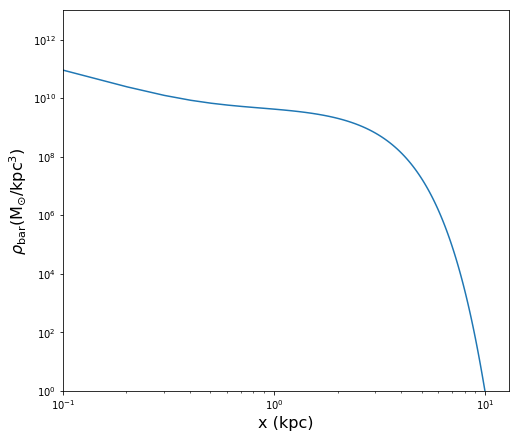

In [3]:
xx=np.linspace(0.,10.,100)
yy=np.zeros(100)
zz=np.zeros(100)

plt.figure(figsize=(8,7))
plt.loglog(xx,rho_bar_norm(zz,yy,xx))
plt.ylim(1.,10**13.)
plt.xlim(0.1,13.)
plt.ylabel(r'$\rho_{\rm{bar}} (\rm{M}_{\odot}/\rm{kpc}^{3})$ ',fontsize=16)
plt.xlabel(r'x (kpc)',fontsize=16)
plt.show()

In [4]:
#define function for the bar density, using form from Dwek (1995) as of now
# transformed from cartesian to cylindrical for galpy

def r1c(R,z,p):
    return ((R**4.)*(np.sin(p)**2./x0**2 + np.cos(p)**2/y0**2)**2 + (z/z0)**4.)**(0.25)

def r2c(R,z):
    return np.sqrt((q*R)**2. + z**2.)/z0


def rho_bar_cyl(R,z,p):
    return np.exp(-r1c(R,z,p)**2./2.) + r2c(R,z)**(-1.85)*np.exp(-r2c(R,z))



In [5]:
ro=8.
vo=220.

Acos,Asin= potential.scf_compute_coeffs(lambda R,z,p: rho_bar_cyl(R*8.,z*8.,p)/bovy_conversion.dens_in_msolpc3(220.,8.),
                                        3,7,a=1./ro)

 #following Pearson et al N=2 and L=6
# a is same as r_s in Wang et al 2012

print Asin

[[[ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00  -0.00000000e+00
    -0.00000000e+00  -0.00000000e+00  -0.00000000e+00]
  [ -0.00000000e+00   1.13765179e-17  -0.00000000e+00  -0.00000000e+00
    -0.00000000e+00  -0.00000000e+00  -0.00000000e+00]
  [ -0.00000000e+00   3.98201733e-19  -1.39395562e-17  -0.00000000e+00
    -0.00000000e+00  -0.00000000e+00  -0.00000000e+00]
  [ -0.00000000e+00  -2.54447256e-17  -8.07859082e-19   1.58889060e-16
    -0.00000000e+00  -0.00000000e+00  -0.00000000e+00]
  [ -0.00000000e+00  -3.11277915e-18   6.01220079e-17  -5.46500284e-19
     3.80172830e-16  -0.00000000e+00  -0.00000000e+00]
  [ -0.00000000e+00   1.50576272e-17  -3.39166272e-18  -6.59192471e-17
    -2.69196905e-18   5.59273620e-16  -0.00000000e+00]
  [ -0.00000000e+00   3.22652059e-17  -9.83783119e-17   4.76789475e-17
    -8.39095102e-18   2.09801803e-17  -8.86700380e-15]]

 [[ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00  -0.00000000e+00
    -0.00000000e+00  -0.00000000e+00  -0.0000

In [9]:
print Acos[0,0,0]/Acos[1,0,0]
print Acos[0,0,0]/Acos[2,0,0]
print Acos[2,0,0]/Acos[1,0,0]

-17.5814289258
-45.3968470311
0.387283040026


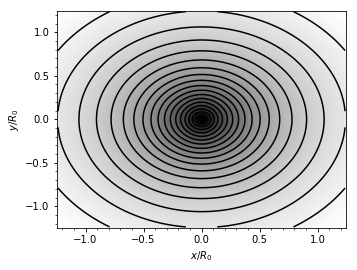

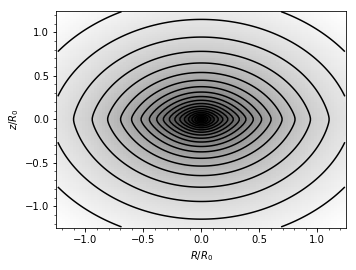

In [10]:
scfbar=potential.SCFPotential(Acos=Acos,Asin=Asin,a=0.125)




pat_speed = 35. #(km/s/kpc)
omegaP=pat_speed*(ro/vo)


scfbarrot=potential.SolidBodyRotationWrapperPotential(amp=0.5, pot=scfbar, omega=omegaP,ro=ro,vo=vo)

MWPotential2014SCFbar= [MWPotential2014[0],MWPotential2014[1],MWPotential2014[2],scfbarrot]

MWPotential2014nobar= [MWPotential2014[0],MWPotential2014[1],MWPotential2014[2]]


potential.plotPotentials(MWPotential2014SCFbar,rmin=-10.*u.kpc,rmax=10.*u.kpc,zmin=-10.*u.kpc,zmax=10.*u.kpc,nrs=100,nzs=100,xy=True)

potential.plotPotentials(MWPotential2014SCFbar,rmin=-10.*u.kpc,rmax=10.*u.kpc,zmin=-10.*u.kpc,zmax=10.*u.kpc,nrs=100,nzs=100,xy=False,phi=0.)

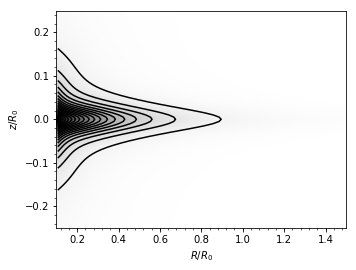

In [11]:
from galpy.potential import plotDensities
plotDensities(MWPotential2014SCFbar,rmin=0.1,zmax=0.25,zmin=-0.25,phi=0.,nrs=101,nzs=101)

236.229087015


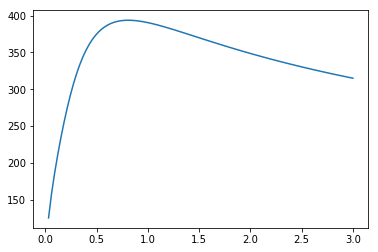

In [86]:
print potential.vcirc(MWPotential2014SCFbar,8.,phi=0)*vo

rr=np.linspace(0.,3.,100)
vcc=[potential.vcirc(MWPotential2014SCFbar,r,phi=0)*vo for r in rr]

plt.figure()
plt.plot(rr,vcc)
plt.show()

In [87]:
from galpy.potential import evaluatezforces
-evaluatezforces(MWPotential2014SCFbar, 1.,1.1/8.,phi=0.,t=1.2)*bovy_conversion.force_in_2piGmsolpc2(220.,8.)

191.59474014533311

In [18]:
#in spherical coordinates

def r1s(R,t,p):
    return R* ( np.sin(t)**4. + np.cos(t)**4.)**(0.25)

def r2s(R,t,p):
    return R*( (q*np.sin(t)/z0)**2. * ((x0*np.cos(p))**2. + (y0*np.sin(p))**2.)  + np.cos(t)**2. )**0.5


def rho_bar_sp(R,t,p):
    return np.exp(-r1s(R,t,p)**2./2.) + r2s(R,t,p)**(-1.85)*np.exp(-r2s(R,t,p))


In [ ]:
#Learn how to use triple quad

from scipy import integrate
import numpy as np

a=2.
b=3.
c=4.

#Return the triple integral of func(z, y, x) from x = a..b, y = gfun(x)..hfun(x), and z = qfun(x,y)..rfun(x,y).

def rfun(x,y):
    return c*np.sqrt(1 - (x/a)**2 - (y/b)**2)

def qfun(x,y):
    return 0.

def gfun(x):
    return 0.

def hfun(x):
    return b*np.sqrt(1-(x/a)**2.)

def ff(z,y,x):
    return 1.

print 8.*integrate.tplquad(ff,0.,2.,gfun,hfun,qfun,rfun)[0]

print 4.*np.pi*a*b*c/3.

In [ ]:
print rho0